In [6]:
from fastai.vision.all import *

model_paths = [
    'resnet50',
    'efficientnet_b3',
    'densenet121',
    'resnet34',
    'mobilenetv3_large_100',
    'mobilenetv3_large_100_v2',
    'mobilenetv3_large_100_v3',
    'efficientnet_b0',
    'resnet50d',                     
    'mobilenetv3_large_100',         
    'densenet121',                 
    'regnety_040',                 
    'ghostnet_100',                
    'maxvit_tiny_rw_224',            
    'efficientformerv2_s0',          
]

learners = {}

for model_path in model_paths:

    full_path = f"../model/{model_path}/model.pkl"
    learn = load_learner(full_path)
    learners[model_path] = learn


learners

/opt/anaconda3/lib/python3.10/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


{'resnet50': <fastai.learner.Learner at 0x33b5396f0>,
 'efficientnet_b3': <fastai.learner.Learner at 0x333cb0760>,
 'densenet121': <fastai.learner.Learner at 0x363e5f7f0>,
 'resnet34': <fastai.learner.Learner at 0x33cbf7340>,
 'mobilenetv3_large_100': <fastai.learner.Learner at 0x363d2f970>,
 'mobilenetv3_large_100_v2': <fastai.learner.Learner at 0x335aa3310>,
 'mobilenetv3_large_100_v3': <fastai.learner.Learner at 0x33b8cb5e0>,
 'efficientnet_b0': <fastai.learner.Learner at 0x33cc7f790>,
 'resnet50d': <fastai.learner.Learner at 0x363c077f0>,
 'regnety_040': <fastai.learner.Learner at 0x36a4a3580>,
 'ghostnet_100': <fastai.learner.Learner at 0x36a4eb6a0>,
 'maxvit_tiny_rw_224': <fastai.learner.Learner at 0x36a6436d0>,
 'efficientformerv2_s0': <fastai.learner.Learner at 0x36b3f3760>}

In [7]:
import json

# Load JSON from file
with open('../model/ensemble_weights.json', 'r') as f:
    model_weights = json.load(f)

model_weights

{'mobilenetv3_large_100': 0.09924083115873755,
 'mobilenetv3_large_100_v2': 0.09924083115873755,
 'mobilenetv3_large_100_v3': 0.09924083115873755,
 'efficientnet_b3': 0.09637499217291971,
 'efficientnet_b0': 0.09499330977830908,
 'ghostnet_100': 0.09462535008094078,
 'resnet34': 0.09165850944645237,
 'resnet50d': 0.09154353324134662,
 'resnet50': 0.09102429628793353,
 'efficientformerv2_s0': 0.09018253177783798,
 'maxvit_tiny_rw_224': 0.08586070559809701,
 'densenet121': 0.08406226393836493,
 'regnety_040': 0.08043367651906061}

In [8]:
class LeanAIEnsembleModel:
    def __init__(self, learners: dict, model_weights: dict):
        """
        learners: dict of {model_name: Learner}
        model_weights: dict of {model_name: float}
        """
        self.learners = learners
        self.model_weights = model_weights

    def predict(self, image_path: str) -> float:
        raw_preds = self.predict_raw(image_path)  # dict: {model_name: prediction}
        
        total_weight = 0.0
        weighted_sum = 0.0

        for model_name, pred in raw_preds.items():
            weight = self.model_weights.get(model_name, 0.0)
            weighted_sum += pred * weight
            total_weight += weight

        if total_weight == 0:
            raise ValueError(f"No valid weights for prediction on '{image_path}'.")

        return weighted_sum / total_weight

    def predict_raw(self, image_path: str) -> dict:
        """
        Return a dict of raw model predictions for the input image.
        e.g., {'resnet50': 14.2, 'efficientnet_b0': 15.1, ...}
        """
        preds = {}
        img = PILImage.create(image_path)

        for model_name, learner in self.learners.items():
            try:
                _, _, output = learner.predict(img)
                preds[model_name] = float(output[0])
            except Exception as e:
                print(f"[Warning] Prediction failed for {model_name}: {e}")
                continue

        return preds


In [9]:
ensemble_model = LeanAIEnsembleModel(learners, model_weights)

In [10]:
ensemble_model.predict('../images/0_image_1.jpg')

9.15321514381041

In [7]:
import pandas as pd
from tqdm.notebook import tqdm

valid_df = pd.read_csv("../data/valid_set.csv")
preds = {}

for idx, row in tqdm(list(valid_df.iterrows()), total=len(valid_df)):
    try: 
        pred = ensemble_model.predict_raw('../images/'+row['filename'])
        preds[row['filename']] = (pred)
    except Exception as e:
        print(e)
        continue

  0%|          | 0/316 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/347_image_1.jpg'


[Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/279_image_1.jpeg'


{'631_image_1.jpg': {'resnet50': 11.956666946411133, 'efficientnet_b3': 12.758407592773438, 'densenet121': 11.987716674804688, 'resnet34': 11.966985702514648, 'mobilenetv3_large_100': 12.15473747253418, 'mobilenetv3_large_100_v2': 12.15473747253418, 'mobilenetv3_large_100_v3': 12.15473747253418, 'efficientnet_b0': 12.186850547790527, 'resnet50d': 13.27979564666748, 'regnety_040': 13.597013473510742, 'ghostnet_100': 12.749849319458008, 'maxvit_tiny_rw_224': 14.348973274230957, 'efficientformerv2_s0': 11.484861373901367}, '395_image_1.png': {'resnet50': 17.289392471313477, 'efficientnet_b3': 13.495281219482422, 'densenet121': 18.31801414489746, 'resnet34': 17.900495529174805, 'mobilenetv3_large_100': 12.510412216186523, 'mobilenetv3_large_100_v2': 12.510412216186523, 'mobilenetv3_large_100_v3': 12.510412216186523, 'efficientnet_b0': 16.18660545349121, 'resnet50d': 14.399502754211426, 'regnety_040': 17.13582992553711, 'ghostnet_100': 13.976480484008789, 'maxvit_tiny_rw_224': 15.7598857879

In [13]:
with open('../model/ensemble_preds.json', 'r') as f:
    preds = json.load(f)

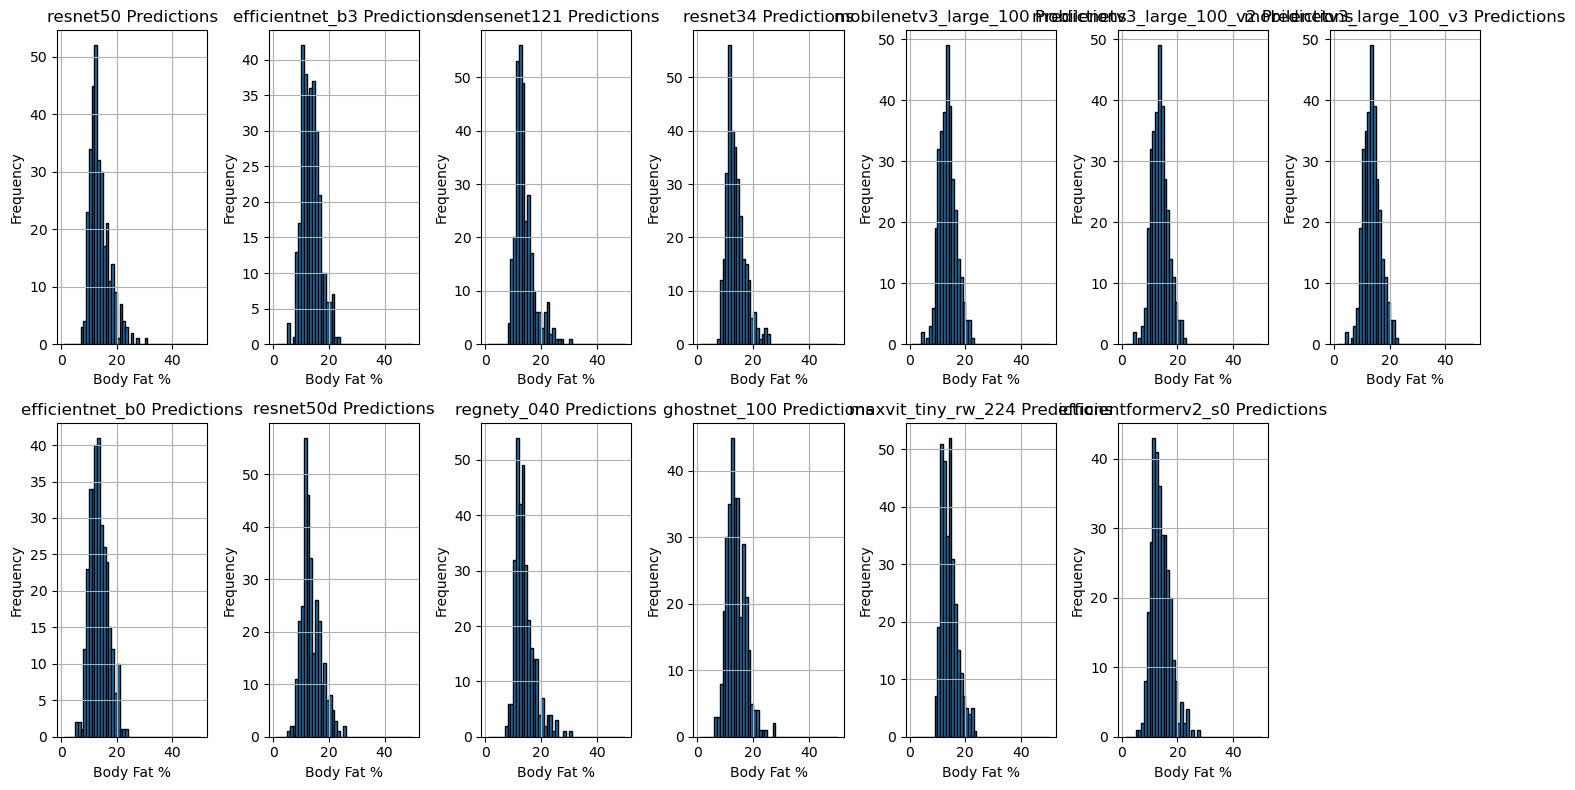

In [14]:
model_preds_dict = {}

# Collect predictions for each model
for img_path, img_preds in preds.items():
    for model, model_pred in img_preds.items():
        if model not in model_preds_dict:
            model_preds_dict[model] = []
        model_preds_dict[model].append(model_pred)

# Plot histograms with consistent bins
bins = np.linspace(1, 50, 50)  # 49 bins from 1 to 50

plt.figure(figsize=(15, 8))
for i, (model, preds_list) in enumerate(model_preds_dict.items(), 1):
    plt.subplot(2, (len(model_preds_dict) + 1) // 2, i)  # Auto layout for subplots
    plt.hist(preds_list, bins=bins, edgecolor='black')
    plt.title(f"{model} Predictions")
    plt.xlabel("Body Fat %")
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()
plt.show()

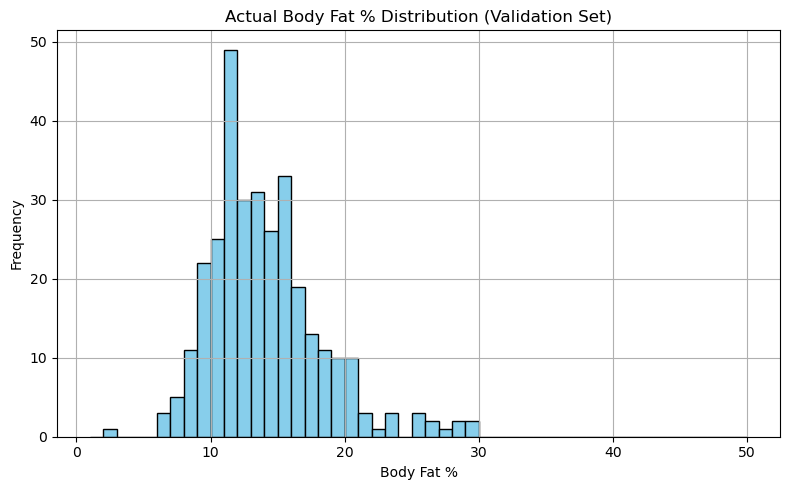

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>


In [16]:
# Load the validation set
valid_df = pd.read_csv("../data/valid_set.csv")

# Plot histogram of actual body fat values
bins = np.linspace(1, 50, 50)  # Uniform bins from 1 to 50

plt.figure(figsize=(8, 5))
plt.hist(valid_df['target'], bins=bins, edgecolor='black', color='skyblue')
plt.title("Actual Body Fat % Distribution (Validation Set)")
plt.xlabel("Body Fat %")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

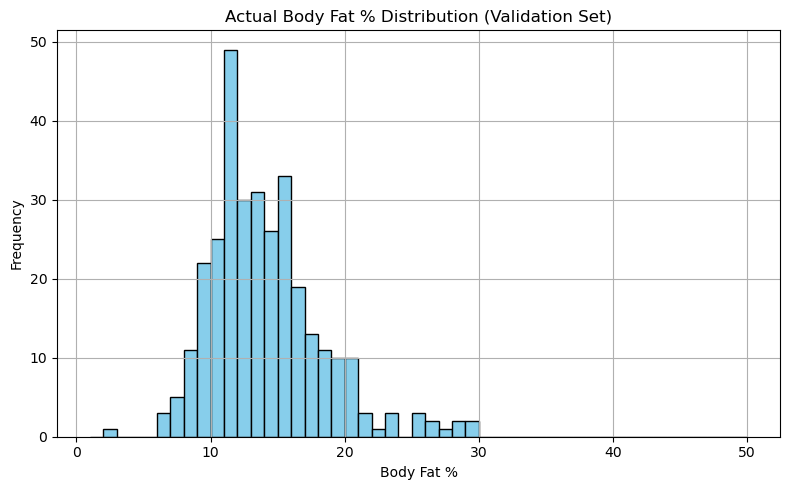

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the validation set
valid_df = pd.read_csv("../data/valid_set.csv")

# Use consistent bins from 1 to 50
bins = np.linspace(1, 50, 50)

# Plot histogram of actual body fat targets
plt.figure(figsize=(8, 5))
plt.hist(valid_df['target'], bins=bins, edgecolor='black', color='skyblue')
plt.title("Actual Body Fat % Distribution (Validation Set)")
plt.xlabel("Body Fat %")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_absolute_error

y_true = []
y_pred = []

filenames = valid_df['filename'].tolist()

for fname in filenames:
    if fname in preds:
        y_true.append(valid_df.loc[valid_df['filename'] == fname, "target"].values[0])
        y_pred.append(preds[fname])


mae = mean_absolute_error(y_true, y_pred)
print(f"Model MAE: {mae}")

In [15]:
# Lets make a pytorch ensemble now 

import torch
import torch.nn as nn


class TorchEnsembleModel(nn.Module):
    def __init__(self, models: list[nn.Module], weights: list[float]):
        super().__init__()
        assert len(models) == len(weights), "Number of models must match number of weights"
        self.models = nn.ModuleList(models)
        self.register_buffer("weights", torch.tensor(weights, dtype=torch.float32))

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        outputs = torch.stack(outputs)  # shape: (num_models, batch_size, output_dim)
        weighted = (outputs * self.weights.view(-1, 1, 1)).sum(dim=0) / self.weights.sum()
        return weighted

    def predict_all(self, x):
        """Returns raw outputs from all submodels."""
        with torch.no_grad():
            return torch.stack([model(x) for model in self.models])  # shape: (num_models, B, output_dim)


In [16]:
models = [learner.model for learner in learners.values()]
weights = [weight for weight in model_weights.values()]

torch_ensemble = TorchEnsembleModel(models, weights)

In [17]:
from torchvision import transforms

def torch_ensemble_predict(image_path: str, ensemble = torch_ensemble, device='cpu'):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load image
    img = Image.open(image_path).convert('RGB')

    # Apply transforms and add batch dimension
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = ensemble(input_tensor)

    return pred.cpu()

In [18]:
model = torch.jit.load('../model/torch_ensemble.pt')

torch_ensemble_predict('../images/0_image_1.jpg', model)


tensor([[9.9604]])

In [19]:
torch_ensemble_predict('../images/0_image_1.jpg')

tensor([[9.9604]])

In [ ]:
ensemble.eval()
model_preds = {f"model_{i}": [] for i in range(len(ensemble.models))}
targets = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)  # if using GPU
        y = y.to(device)
        raw_outputs = ensemble.predict_all(x)  # shape: (num_models, B, output_dim)

        for i in range(raw_outputs.size(0)):
            model_preds[f"model_{i}"].append(raw_outputs[i].cpu().squeeze().numpy())

        targets.append(y.cpu().squeeze().numpy())

# Combine predictions
for k in model_preds:
    model_preds[k] = np.concatenate(model_preds[k])
targets = np.concatenate(targets)


In [35]:
import pandas as pd
from tqdm.notebook import tqdm

valid_df = pd.read_csv("../data/valid_set.csv")
preds = {}

for idx, row in tqdm(list(valid_df.iterrows()), total=len(valid_df)):
    try: 
        pred = torch_ensemble_predict('../images/'+row['filename'])
        preds[row['filename']] = pred[0]
    except Exception as e:
        print(e)
        continue


  0%|          | 0/316 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/347_image_1.jpg'
[Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/279_image_1.jpeg'
{'631_image_1.jpg': tensor([11.8290]), '395_image_1.png': tensor([15.2334]), '598_image_1.jpeg': tensor([13.2494]), '258_image_3.jpg': tensor([16.6172]), '248_image_1.jpg': tensor([11.3338]), '767_image_1.png': tensor([14.5696]), '251_image_1.jpg': tensor([15.9641]), '133_image_1.jpeg': tensor([14.0504]), '241_image_1.jpg': tensor([12.1596]), '32_image_3.jpg': tensor([11.7733]), '327_image_1.jpg': tensor([9.0869]), '501_image_1.png': tensor([13.2706]), '378_image_3.jpg': tensor([15.0050]), '665_image_1.jpg': tensor([18.3191]), '324_image_3.jpg': tensor([13.5093]), '175_image_1.jpg': tensor([15.8700]), '693_image_1.jpg': tensor([11.5779]), '14_image_2.jpg': tensor([21.1209]), '15_image_1.jpg': tensor([11.5043]), '775_image_4.jpg': tenso

In [36]:
from sklearn.metrics import mean_absolute_error

y_true = []
y_pred = []



filenames = valid_df['filename'].tolist()

for fname in filenames:
    if fname in preds:
        y_true.append(valid_df.loc[valid_df['filename'] == fname, "target"].values[0])
        y_pred.append(preds[fname])


mae = mean_absolute_error(y_true, y_pred)
print(f"Model MAE: {mae}")

Model MAE: 2.0480791293587655


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, preds in model_preds.items():
    plt.hist(preds, bins=30, alpha=0.5, label=name)

plt.title("Validation Predictions - Histogram by Model")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
torch_ensemble.eval()

TorchEnsembleModel(
  (models): ModuleList(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [11]:
example_input = torch.randn(1, 3, 224, 224)

In [12]:
single_model = torch_ensemble.models[0]
single_model.eval()
traced_single = torch.jit.trace(single_model, example_input)

print('done')

done


In [13]:
traced_model = torch.jit.trace(torch_ensemble, example_input)

print('done')

/opt/anaconda3/lib/python3.10/site-packages/torch/__init__.py:2150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


done


In [14]:
traced_model.save("../model/torch_ensemble.pt")